# Setup colab gang

> **IMPORTANT**
> Nel caso si utilizzi google Colab c'è da caricare i file di input.

In [1]:
#from google.colab import drive
#
#drive.mount('/content/drive')

path = '/content/drive/MyDrive/PoliMI/Dataset1_BankClients.xlsx'

# Setup locale

In [2]:
# Path su linux
path = './data/Dataset1_BankClients.xlsx'

# Path su windows - comando da inserire 
#path = ' '

# Utility Functions


Auxuliary functions to avoid code repetition:
- `get_optimal_k_voting`: given a list of predictions, it returns the optimal number of cluster to consider for the final prediction.
- `visualize_predictions`: given a list of predictions, it plots the predictions and the optimal number of votes to consider for the final prediction.

In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA, FastICA

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import matplotlib.pyplot as plt

def get_optimal_k_voting(X, cluster_results, gower_distances):
    """
    Determine the optimal number of clusters (k) by voting among different metrics.
    
    Parameters:
    - X: Dataset (used for Calinski-Harabasz and Davies-Bouldin scores)
    - cluster_results: Dictionary where keys are k values and values are cluster assignments
    - gower_distances: Precomputed Gower distance matrix (used for Silhouette score)
    
    Returns:
    - optimal_k: The optimal number of clusters based on the median of suggested k values
    """
    
    if not cluster_results:
        raise ValueError("cluster_results cannot be empty")
    
    k_values = list(cluster_results.keys())
    
    # Validate cluster assignments
    for k, assignments in cluster_results.items():
        if len(assignments) != len(X):
            raise ValueError(f"Cluster assignments for k={k} do not match dataset size")
    
    # Get optimal k for each metric
    try:
        ch_optimal = k_values[np.argmax(calinski_harabasz_score(X, cluster_results[k]) for k in k_values)]
        # print("DEBUG: ", ch_optimal)
        # print("Calinski-Harabasz Score (k=3):", calinski_harabasz_score(X, cluster_results[3]))
        # print("Calinski-Harabasz Score (k=4):", calinski_harabasz_score(X, cluster_results[4]))
    except ValueError as e:
        print(f"Warning: Calinski-Harabasz score failed. Skipping. Error: {e}")
        ch_optimal = None
    
    try:
        db_scores = {k: davies_bouldin_score(X, cluster_results[k]) for k in k_values}
        db_optimal = min(db_scores, key=db_scores.get)
        
        # print("DEBUG: ", db_optimal)
        # print("Davies-Bouldin Score (k=3):", db_scores[3])
        # print("Davies-Bouldin Score (k=4):", db_scores[4])
    except ValueError as e:
        print(f"Warning: Davies-Bouldin score failed. Skipping. Error: {e}")
        db_optimal = None

    
    try:
        # Correctly identify the optimal k based on the Silhouette score
        sil_scores = {k: silhouette_score(gower_distances, cluster_results[k], metric='precomputed') for k in k_values}
        sil_optimal = max(sil_scores, key=sil_scores.get)
        
        # print("DEBUG: ", sil_optimal)
        # print("Silhouette Score (k=3):", sil_scores[3])
        # print("Silhouette Score (k=4):", sil_scores[4])
    except ValueError as e:
        print(f"Warning: Silhouette score failed. Skipping. Error: {e}")
        sil_optimal = None
    
    # Collect valid suggestions
    suggestions = [k for k in [ch_optimal, db_optimal, sil_optimal] if k is not None]
    print("Suggestions:", suggestions)
    
    if not suggestions:
        raise ValueError("No valid suggestions from metrics")
    
    # Get median k
    optimal_k = int(np.median(suggestions))
    
    # Print results
    print("\nVoting Results:")
    if ch_optimal is not None:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, cluster_results[ch_optimal])}")
    if db_optimal is not None:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, cluster_results[db_optimal])}")
    if sil_optimal is not None:
        print(f"Silhouette score: {silhouette_score(gower_distances, cluster_results[sil_optimal], metric='precomputed')}")
    print(f"\nFinal decision (median): {optimal_k} clusters")
    
    return optimal_k

def visualize_cluster(X, clusters):
    """
    Visualize the clustering results in 2D and 3D space using PCA and ICA.
    Parameters:
    - X: Dataset
    - clusters: Cluster assignments
    """
    # Import necessary libraries
    from sklearn.decomposition import PCA, FastICA
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
    import numpy as np

    # PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    # Create subplots for PCA visualization
    fig_pca = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        horizontal_spacing=0.15,
        subplot_titles=["2-D Embedding with PCA", "3-D Embedding with PCA"]
    )
    
    # Add points for each cluster
    unique_clusters = np.unique(clusters)
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
    
    for cluster in unique_clusters:
        # Get points in current cluster
        cluster_points = X_pca[clusters == cluster]
        
        # Select color for the cluster
        cluster_color = colors[cluster % len(colors)]
        
        # Add points for 2D scatter
        fig_pca.add_trace(
            go.Scatter(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=8
                ),
                name=f'Cluster {cluster} Points',
                showlegend=True,
                legendgroup=f'group{cluster}',
                xaxis='x',
                yaxis='y'
            )
        )
        
        # Add points for 3D scatter
        fig_pca.add_trace(
            go.Scatter3d(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                z=cluster_points[:, 2],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=5
                ),
                name=f'Cluster {cluster} Points 3D',
                showlegend=True,
                legendgroup=f'group{cluster}'
            )
        )
    
    # Update 2D layout
    fig_pca.update_xaxes(title_text="Principal Component 1")
    fig_pca.update_yaxes(title_text="Principal Component 2")
    
    # Update 3D layout
    fig_pca.update_layout(
        scene=dict(
            xaxis_title="Principal Component 1",
            yaxis_title="Principal Component 2",
            zaxis_title="Principal Component 3"
        )
    )
    
    # ICA
    ica = FastICA(n_components=3, random_state=42)
    X_ica = ica.fit_transform(X)
    
    # Create subplots for ICA visualization
    fig_ica = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        horizontal_spacing=0.15,
        subplot_titles=["2-D Embedding with ICA", "3-D Embedding with ICA"]
    )
    
    # Add points for each cluster
    for cluster in unique_clusters:
        # Get points in current cluster
        cluster_points = X_ica[clusters == cluster]
        
        # Select color for the cluster
        cluster_color = colors[cluster % len(colors)]
        
        # Add points for 2D scatter
        fig_ica.add_trace(
            go.Scatter(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=8
                ),
                name=f'Cluster {cluster} Points',
                showlegend=True,
                legendgroup=f'group{cluster}',
                xaxis='x',
                yaxis='y'
            )
        )
        
        # Add points for 3D scatter
        fig_ica.add_trace(
            go.Scatter3d(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                z=cluster_points[:, 2],
                mode='markers',
                marker=dict(
                    color=cluster_color,
                    opacity=0.8,
                    size=5
                ),
                name=f'Cluster {cluster} Points 3D',
                showlegend=True,
                legendgroup=f'group{cluster}'
            )
        )
    
    # Update 2D layout
    fig_ica.update_xaxes(title_text="Independent Component 1")
    fig_ica.update_yaxes(title_text="Independent Component 2")
    
    # Update 3D layout
    fig_ica.update_layout(
        scene=dict(
            xaxis_title="Independent Component 1",
            yaxis_title="Independent Component 2",
            zaxis_title="Independent Component 3"
        )
    )
    
    # Show both visualizations
    fig_pca.show()
    fig_ica.show()

# Data Loading

In [ ]:
import pandas as pd

# Load data in a DataFrame
data = pd.read_excel(path)

# Let's inspect the first 5 record
print(data.head())
# Drop the column by its actual name (e.g., 'ID' or the actual name of the column)
data = data.drop(columns=['ID'])  # Replace 'ID' with the actual column name to drop

# Test without esg and bankfriend
#data = data.drop(columns=['ESG', 'BankFriend'])

   ID  Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth  \
0   1   24       1    1     2         2           4  0.668046  0.702786   
1   2   47       1    2     2         3           1  0.858453  0.915043   
2   3   38       0    2     1         2           2  0.926818  0.898316   
3   4   67       0    2     1         2           3  0.538797  0.423180   
4   5   33       0    2     1         3           1  0.806659  0.731404   

       Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury  \
0  0.262070  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369   
1  0.730430  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729   
2  0.441272  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199   
3  0.600401  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209   
4  0.831449  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610   

     Saving  Investments  
0  0.283222            1  
1  0.821590            3  

# Data Preparation  

In [37]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

# Specify categorical variables
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
#categorical_columns = ['Gender', 'Job', 'Area', 'CitySize']


# Split variables
numerical_features = data.drop(columns=categorical_columns)  # Exclude categorical variables
categorical_features = data[categorical_columns]  # Select categorical variables

# Convert categorical in typ 'category' (for OneHotEncoder)
categorical_features = categorical_features.astype('category')

# Normalize numerical variables
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical_features)

# One-hot encoding categorical variables
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Dummy encoding - set 1 feature to all 0s - ignoring unknwown values
X_cat = encoder.fit_transform(categorical_features).toarray()  # Convert into a dense matrix

# Concatenation of numerical and categorical variables
X = np.hstack((X_num, X_cat))

# Summary of the dataset
print("Numerical Features Shape:", X_num.shape)
print("Categorical Features Shape:", X_cat.shape)
print("Combined Features Shape:", X.shape)


Numerical Features Shape: (5000, 10)
Categorical Features Shape: (5000, 11)
Combined Features Shape: (5000, 21)


# Data Exploration 

Firstly, control covariances of numerical features between features and target variable. We can see that the most correlated features have a correlation of 0.05

In [6]:
import matplotlib.pyplot as plt

# Covariance matrix of numerical features
cov_matrix = np.cov(X_num.T)
print("Covariance Matrix Shape:", cov_matrix.shape) 

# Plot the covariance matrix
# plt.figure(figsize=(10, 10))
# plt.imshow(cov_matrix, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.title('Covariance Matrix of Numerical Features')
# plt.show()

Covariance Matrix Shape: (12, 12)


# Clustering 

In [7]:
# PCA - Principal Component Analysis

from sklearn.decomposition import PCA

# PCA model
pca = PCA(n_components= X.shape[1])  # Number of components = number of features
X_pca = pca.fit_transform(X)

# Print cumulative explained variance of each principal component
print("Explained Variance Ratio:\n", pca.explained_variance_ratio_)

# First 20 principal components
print("First 20 Principal Components:\n", sum(pca.explained_variance_ratio_[:20]))



Explained Variance Ratio:
 [0.20206954 0.1492904  0.11530077 0.10203741 0.06749837 0.05927208
 0.03979074 0.03705638 0.032703   0.03007122 0.02869856 0.02426222
 0.01465202 0.01330915 0.01201979 0.01116348 0.01077602 0.00985505
 0.00971618 0.0086971  0.00847828 0.00758303 0.00569919]
First 20 Principal Components:
 0.9782394995834919


In [8]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import numpy as np
import gower

# Compute Gower distance matrix
gower_distance = gower.gower_matrix(data)

# Perform hierarchical clustering
Z = linkage(gower_distance, method='ward')

# Plot dendrogram
# plt.figure(figsize=(15, 10))
# dendrogram(Z)
# plt.title('Dendrogram')
# plt.show()

# Cut the dendrogram at a certain height to obtain clusters
cluster3 = fcluster(Z, 3, criterion='maxclust')
cluster4 = fcluster(Z, 4, criterion='maxclust')

# Print the number of clusters
print("Number of Clusters (k=3):", len(np.unique(cluster3)))
print("Number of Clusters (k=4):", len(np.unique(cluster4)))

# Silhouette score for k=3
silhouette_score3 = silhouette_score(gower_distance, cluster3, metric='precomputed')
print("Silhouette Score (k=3):", silhouette_score3)

# Silhouette score for k=4
silhouette_score4 = silhouette_score(gower_distance, cluster4, metric='precomputed')
print("Silhouette Score (k=4):", silhouette_score4)

cluster_results = {}
cluster_results[3] = cluster3
cluster_results[4] = cluster4

# Get the optimal k through robust voting
final_k = get_optimal_k_voting(X, cluster_results, gower_distance)
#visualize_cluster(X, cluster_results[final_k])


/tmp/ipykernel_20447/3070669675.py:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_distance, method='ward')


Number of Clusters (k=3): 3
Number of Clusters (k=4): 4
Silhouette Score (k=3): 0.16274703
Silhouette Score (k=4): 0.17566182
Suggestions: [3, 4, 4]

Voting Results:
Calinski-Harabasz score: 545.743012547759
Davies-Bouldin score: 2.414386141141969
Silhouette score: 0.1756618171930313

Final decision (median): 4 clusters


In [ ]:
from sklearn.cluster import KMeans

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_clusters3 = kmeans.predict(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
kmeans_clusters4 = kmeans.predict(X)

# Choose the optimal number of clusters
cluster_results = {}
cluster_results[3] = kmeans_clusters3
cluster_results[4] = kmeans_clusters4
final_k = get_optimal_k_voting(X, cluster_results, gower_distance)

# Visualize the clustering resultsKMeans
#visualize_cluster(X, cluster_results[final_k])


Suggestions: [3, 4, 3]

Voting Results:
Calinski-Harabasz score: 697.4870369790111
Davies-Bouldin score: 2.1273736583209124
Silhouette score: 0.09437069296836853

Final decision (median): 3 clusters


In [32]:
from sklearn.cluster import KMeans

# PCA
pca = PCA(n_components=3)  # 3 PC
X_pca = pca.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)
kmeans_clusters2 = kmeans.predict(X_pca)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)
kmeans_clusters3 = kmeans.predict(X_pca)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_pca)
kmeans_clusters4 = kmeans.predict(X_pca)

# Choose the optimal number of clusters
cluster_results = {}
cluster_results[2] = kmeans_clusters2
cluster_results[3] = kmeans_clusters3
cluster_results[4] = kmeans_clusters4
final_k = get_optimal_k_voting(X_pca, cluster_results, gower_distance)
#visualize_cluster(X, cluster_results[final_k])


Suggestions: [2, 4, 3]

Voting Results:
Calinski-Harabasz score: 2084.3224365770743
Davies-Bouldin score: 0.9801832588444652
Silhouette score: 0.12172053009271622

Final decision (median): 3 clusters


In [31]:
from sklearn.decomposition import FastICA

# PCA
ica = FastICA(n_components=3)  # 3 PC
X_ica = ica.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_ica)
kmeans_clusters2 = kmeans.predict(X_ica)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_ica)
kmeans_clusters3 = kmeans.predict(X_ica)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_ica)
kmeans_clusters4 = kmeans.predict(X_ica)

# Choose the optimal number of clusters
cluster_results = {}
cluster_results[2] = kmeans_clusters2
cluster_results[3] = kmeans_clusters3
cluster_results[4] = kmeans_clusters4
final_k = get_optimal_k_voting(X, cluster_results, gower_distance)
#visualize_cluster(X, cluster_results[final_k])

Suggestions: [2, 4, 2]

Voting Results:
Calinski-Harabasz score: 819.9403314301767
Davies-Bouldin score: 2.0623105895991567
Silhouette score: 0.119017593562603

Final decision (median): 2 clusters


# Distance Tests

In [95]:
import numpy as np
from scipy.spatial.distance import cdist, mahalanobis
from scipy.linalg import inv

def vectorized_mahalanobis(X_num, inv_cov_matrix):
    """
    Vectorized Mahalanobis distance calculation
    Returns square matrix of pairwise distances
    """
    # Compute differences between all pairs of points
    diff = X_num[:, np.newaxis] - X_num[np.newaxis, :]
    
    # Matrix multiplication approach for Mahalanobis distance
    return np.sqrt(np.sum(diff @ inv_cov_matrix * diff, axis=-1))

def vectorized_euclidean(X_num):
    """
    Vectorized Mahalanobis distance calculation
    Returns square matrix of pairwise distances
    """
    # Compute differences between all pairs of points
    diff = X_num[:, np.newaxis] - X_num[np.newaxis, :]
    
    # Matrix multiplication approach for Mahalanobis distance
    return np.sqrt(np.sum(diff * diff, axis=-1))

def vectorized_overlap(X_cat):
    """
    Vectorized overlap distance calculation
    Returns square matrix of pairwise distances
    """
    # Compute minimum between all pairs of points
    min_size = np.minimum(
        X_cat.sum(axis=1)[:, np.newaxis],
        X_cat.sum(axis=1)[np.newaxis, :]
    )
    
    # Compute intersection sum for all pairs
    intersection = np.minimum(X_cat[:, np.newaxis], X_cat[np.newaxis, :]).sum(axis=-1)
    
    # Handle division by zero
    mask = min_size > 0
    result = np.ones_like(min_size, dtype=float)
    result[mask] = 1 - intersection[mask] / min_size[mask]

    # Set diagonal to zero
    np.fill_diagonal(result, 0)
    
    return result

# Drop age to numerical features
X_num = np.delete(X_num, 0, axis=1)

# Discretize Age 
age = data['Age']
age_bins = [0, 35, 65]
age_labels = [0, 1, 2]
# full of zero 
age_discretized = np.zeros((len(age), 1))
for i in range(len(age)):
    for j in range(len(age_bins)):
        if age[i] >= age_bins[j]:
            age_discretized[i] = age_labels[j]
            break

# Compute covariance matrix and its inverse
cov_matrix = np.cov(X_num.T)
inv_cov_matrix = inv(cov_matrix)

# Calculate distances
num_dist = vectorized_mahalanobis(X_num, inv_cov_matrix)
cat_dist = vectorized_overlap(X_cat)

# Combine weighted distances
w_num = 0.5
w_cat = 1 - w_num
#w_num, w_cat = 0, 1
# Normalize distances
num_dist = num_dist / np.max(num_dist)

custom_dist = w_num*num_dist + w_cat*cat_dist

print(f'Dimension of custom_dist = {custom_dist.shape}')

Dimension of custom_dist = (5000, 5000)


In [96]:
print("Max distance: ", np.max(custom_dist))
print("Min distance: ", np.min(custom_dist))
print("Mean distance: ", np.mean(custom_dist))

# Check if exist non-zero diag elem
print("Non-zero diagonal values:", np.any(np.diag(custom_dist) != 0))

# print non zero diagonal elements
print("Non-zero diagonal values:", np.diag(custom_dist)[np.diag(custom_dist) != 0]) 

# Check symmetry
print("Symmetry check:", np.allclose(custom_dist, custom_dist.T))

Max distance:  0.9997392588717969
Min distance:  0.0
Mean distance:  0.4562665765197912
Non-zero diagonal values: False
Non-zero diagonal values: []
Symmetry check: True


In [97]:
from sklearn_extra.cluster import KMedoids

# Perform k-means clustering
kmeans = KMedoids(n_clusters=2, random_state=42)
kmeans.fit(custom_dist)
kmeans_clusters2 = kmeans.predict(custom_dist)


# Perform k-means clustering
kmeans = KMedoids(n_clusters=3, random_state=42)
kmeans.fit(custom_dist)
kmeans_clusters3 = kmeans.predict(custom_dist)

# Perform k-means clustering
kmeans = KMedoids(n_clusters=4, random_state=42)
kmeans.fit(custom_dist)
kmeans_clusters4 = kmeans.predict(custom_dist)

# Choose the optimal number of clusters
cluster_results = {}
cluster_results[2] = kmeans_clusters2
cluster_results[3] = kmeans_clusters3
cluster_results[4] = kmeans_clusters4
final_k = get_optimal_k_voting(X, cluster_results, custom_dist)

# Visualize the clustering results
visualize_cluster(X, cluster_results[final_k])



Suggestions: [2, 4, 2]

Voting Results:
Calinski-Harabasz score: 746.4897777780179
Davies-Bouldin score: 2.1589414793181856
Silhouette score: 0.23642732023160778

Final decision (median): 2 clusters


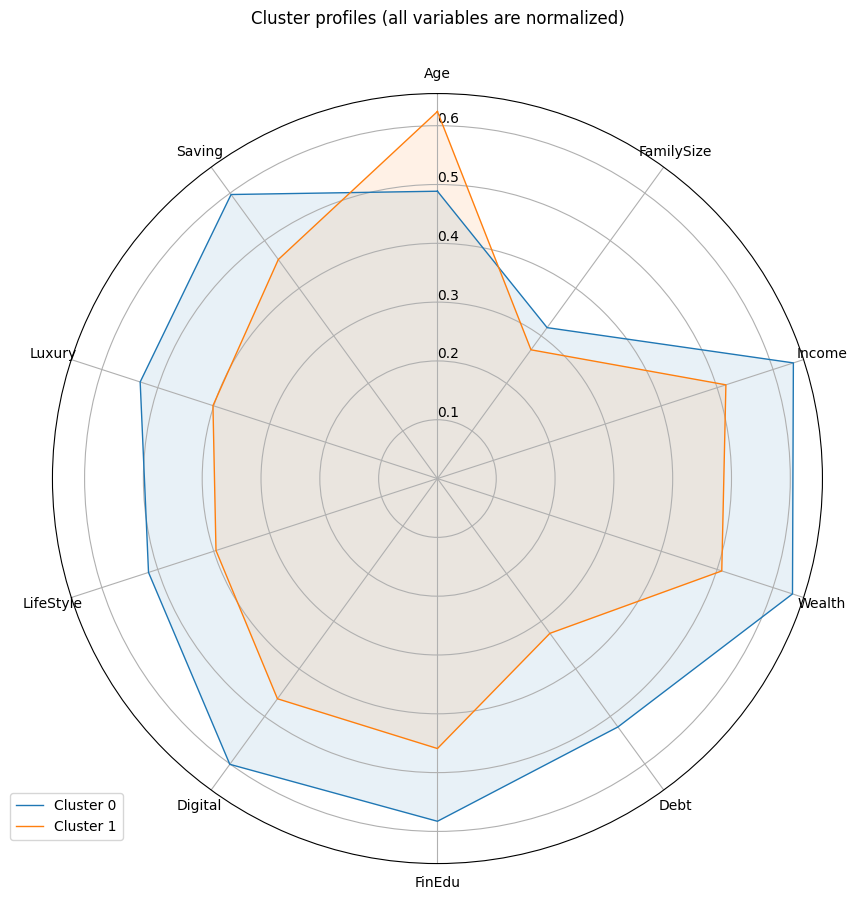

In [98]:
def plot_cluster_radar(data):
    # Create a copy of the data for normalization
    plot_data = data.copy()

    # Normalize all numerical variables using MinMaxScaler
    scaler = MinMaxScaler()
    plot_data[numerical_features.columns] = scaler.fit_transform(plot_data[numerical_features.columns])

    # Calculate mean values for each numerical variable by cluster
    cluster_means = plot_data.groupby('Cluster')[numerical_features.columns].mean()

    # Set up the radar chart
    categories = numerical_features.columns
    num_vars = len(categories)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Plot for each cluster
    for cluster in range(data['Cluster'].nunique()):
        values = cluster_means.loc[cluster].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)

    # Set chart properties
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], categories)
    ax.set_title("Cluster profiles (all variables are normalized)", y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

# Radar chart
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = cluster_results[final_k]

plot_cluster_radar(data_with_clusters)

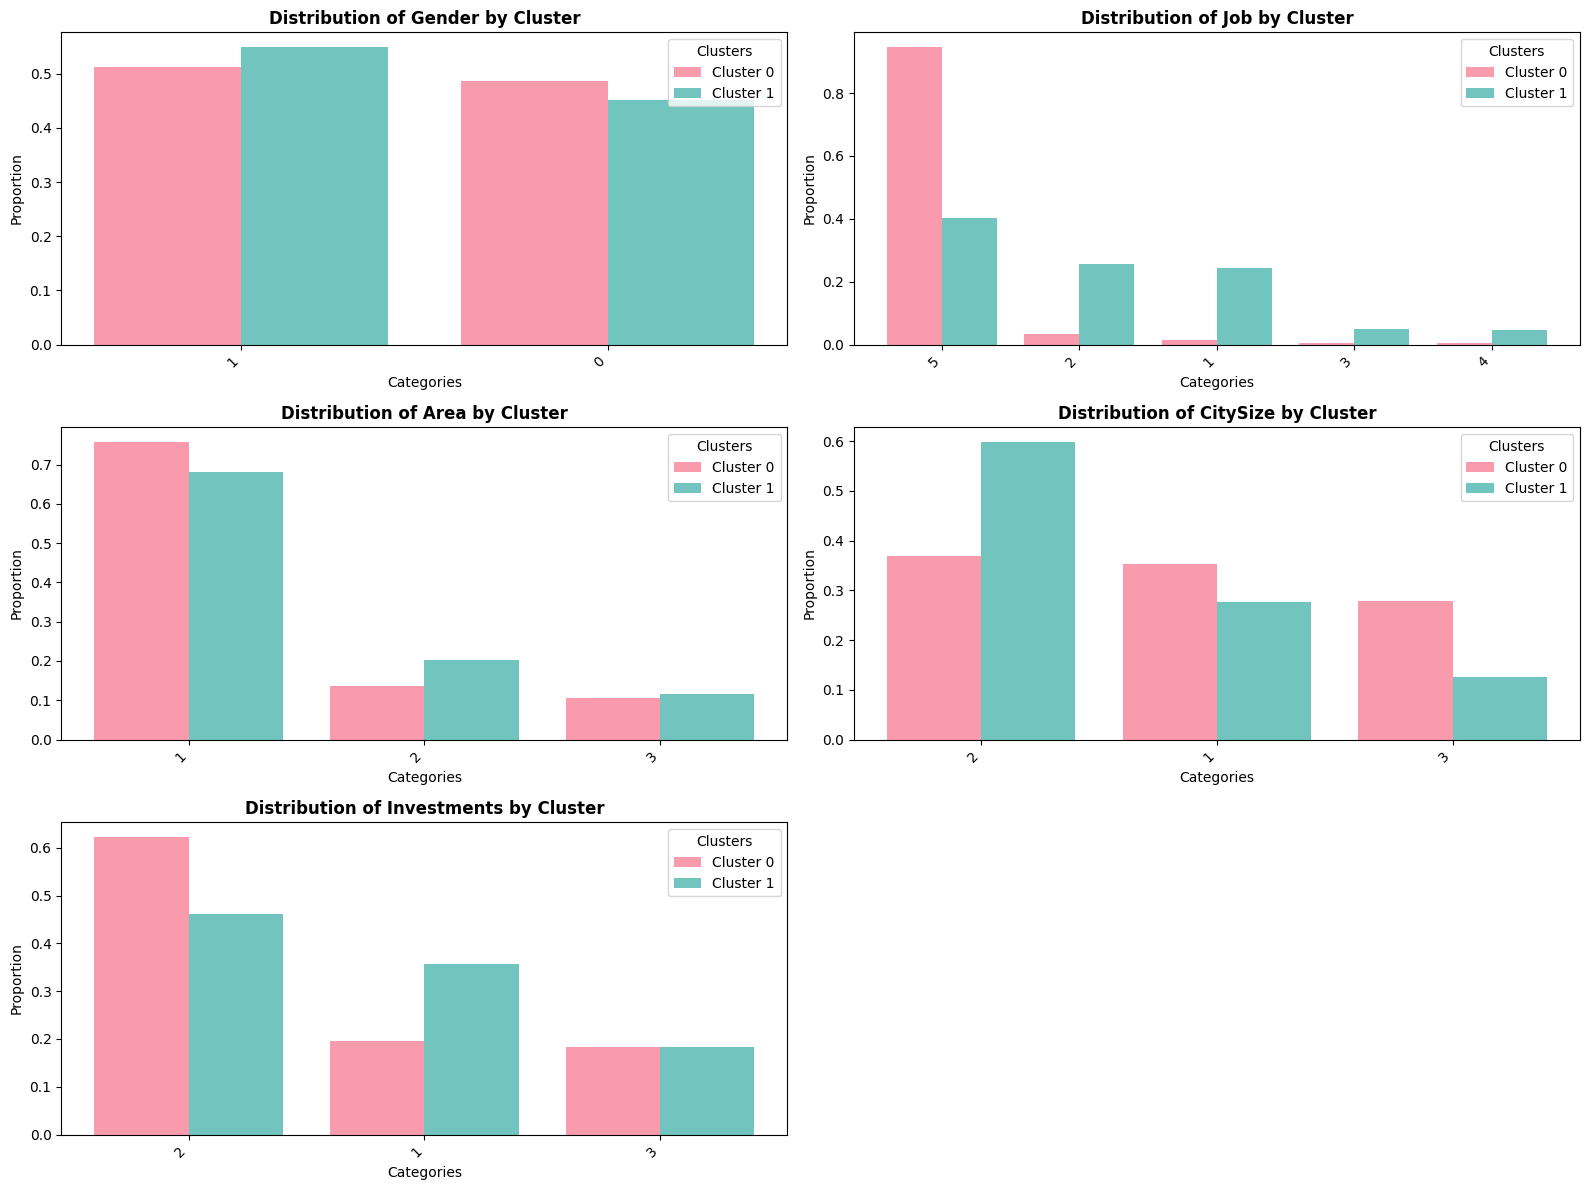

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_cluster_histograms(data, categorical_features=None, max_categories=10):
    """
    Create comprehensive histogram visualization for categorical features by cluster.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing clustering data
    categorical_features : list or None, optional
        List of categorical feature names to plot. 
        If None, automatically detect categorical columns.
    max_categories : int, optional
        Maximum number of unique categories to display per feature
    
    Returns:
    --------
    matplotlib.figure.Figure or None
        The created figure or None if no categorical features found
    """
    # Create a copy of the data
    plot_data = data.copy()
    
    # Automatically detect categorical features if not provided
    if categorical_features is None:
        categorical_features = plot_data.select_dtypes(include=['object', 'category']).columns.tolist()
    else:
        # Ensure categorical_features is a list
        categorical_features = list(categorical_features)
    
    # Check if there are any categorical features
    if not categorical_features:
        print("No categorical features found to plot.")
        return None
    
    # Determine number of subplots needed
    n_features = len(categorical_features)
    n_rows = max(1, int(np.ceil(n_features / 2)))
    n_cols = min(2, n_features)
    
    # Set up a more sophisticated color palette
    palette = sns.color_palette("husl", n_colors=plot_data['Cluster'].nunique())
    
    # Create figure with more professional styling
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    
    # Ensure axes is always a 2D array
    if n_features == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Iterate through categorical features
    for i, column in enumerate(categorical_features):
        # Get current axis
        ax = axes_flat[i]
        
        # Prepare data
        feature_data = []
        labels = []
        
        # Collect data for each cluster
        for cluster in sorted(plot_data['Cluster'].unique()):
            cluster_subset = plot_data[plot_data['Cluster'] == cluster]
            
            # Count and normalize value counts
            value_counts = cluster_subset[column].value_counts(normalize=True)
            
            # Limit to top categories
            value_counts = value_counts.nlargest(max_categories)
            
            feature_data.append(value_counts)
            labels.append(f'Cluster {cluster}')
        
        # Plot grouped bar chart
        width = 0.8 / len(feature_data)
        for j, (cluster_counts, label) in enumerate(zip(feature_data, labels)):
            x = np.arange(len(cluster_counts))
            ax.bar(x + j*width, cluster_counts.values, 
                   width=width, 
                   label=label, 
                   alpha=0.7, 
                   color=palette[j])
        
        # Customize plot
        ax.set_title(f'Distribution of {column} by Cluster', fontweight='bold')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Proportion')
        
        # Set x-ticks
        ax.set_xticks(x + width * (len(feature_data) - 1) / 2)
        ax.set_xticklabels(cluster_counts.index, rotation=45, ha='right')
        
        # Add legend
        ax.legend(title='Clusters', loc='best')
    
    # Remove extra subplots if any
    for j in range(i+1, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Plot the histograms
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
fig = plot_cluster_histograms(data_with_clusters, categorical_features=categorical_columns)
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

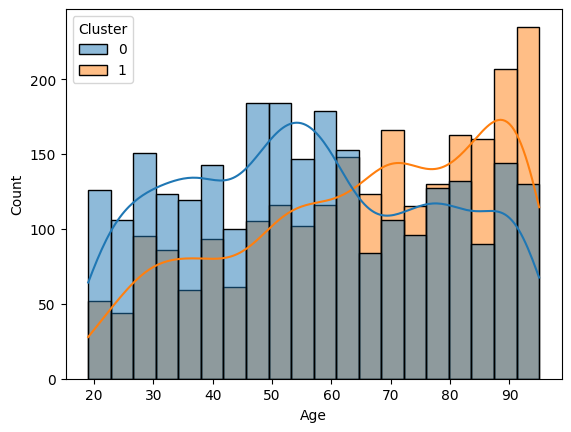

In [ ]:
# histogram of the age variable
sns.histplot(data_with_clusters, x='Age', hue='Cluster', kde=True, bins=20)

# histogram of the age variable
#sns.histplot(data, x='Age', kde=True, bins=20)